# COLLAB DE MODELISATION

## Avant de commencer, modifier les constances de la première cellule

*   Avoir créé branche neuve depuis le master et pousser tout le code sur votre Drive
*   Créer des modèles texte, image et/ou fusion dans les fichiers 
  * Ecrire vos modèles dans ```src/models/models_text.py```, ```src/models/models_image.py``` et/ou ```src/models/models_fusion.py```
  * Ajouter-les dans `build_pipeline_model` dans `image.py`, `text.py` et/ou `fusion.py`
  * Modifier `MODEL_TEXT_NAME`, `MODEL_IMAGE_NAME` et/ou `MODEL_FUSION_NAME`
*   Modifier le chemin d'accès `PATH_PROJECT` vers votre dossier du projet à vous
*   Avoir les photos en `500x500`
  * Créer un fichier `.zip` sur votre ordi et y mettre toutes les photos du dossier ```images/image_train```
  * Uploader ce fichier sur votre Drive
  * Adapter ```LIEN_VERS_ZIP``` de la cellule ```shutil.unpack_archive```
  * Mettre la constante ```UNZIP``` à True
  * Vérifier que les photos sont bien dans ```xxx/data/raw/images/image_train```
* Exécuter tout code suivant



## Rapport de modélisation partie Mo:
La première modélisation s'est opérée avec SVM car il est le modèle le plus efficace pour la reconnaissance d'objet. Le score obtenu a été de 0.3. Ce score médiocre n'est pas suffisant et un modèle plus avancé a été proposé qui est l'arbre de décision boosté. Olga qui a aussi travaillé sur les modèles de classification de ML a elle aussi obtenu des résultats non satisfaisant. Elle a quant à elle réalisé une cross validation avec des grilles et elle a travaillé sur les métriques.  En fait les modèles de classification de Machine learning ne sont pas assez puissants pour notre problèmatique et il faut passer au deep learning. Il est présenté plus bas un modèle de classification par réseau de neurone. Le CNN en question est le Lenet. Les résultats sont bien meilleurs car ils avoisinent les 0.85 mais le réseau réalise de l'overfiting et la val_accuracy est faible, elle est aux environs de 0,2.

In [12]:
PATH_PROJECT = "/content/drive/MyDrive/Rakuten"

MODEL_TEXT_NAME = "nn_simple"
MODEL_IMAGE_NAME = "mo_cnn_basic"
MODEL_FUSION_NAME = "fusion_simple"

UNZIP = False #Pour dezipper les fichiers
CHECK_IMAGES = False # Pour verifier que tout le monde ait bien le bon nmbre d'images

TRAIN_IMAGE = False #Pour entrainer le modele d'image MODEL_IMAGE_NAME
TRAIN_TEXT = False #Pour entrainer le modele d'image MODEL_TEXT_NAME
TRAIN_FUSION = True #Pour entrainer le modele d'image MODEL_FUSION_NAME

BATCH_SIZE = 32
EPOCHS_IMAGE = 5
EPOCHS_TEXT = 5
EPOCHS_FUSION = 10
TARGET_SHAPE = (224, 224, 3) #Taille néssaire pour VGG16

## CODE
### Mise en place

In [2]:
# Chargement du dashboard TensorBoard
%reload_ext tensorboard

In [3]:
# Ajout de Drive au syspath
from google.colab import drive
import sys

drive.mount('/content/drive', force_remount=True)
sys.path.insert(0, PATH_PROJECT)

Mounted at /content/drive


In [4]:
# Ajout d'imports specifiques pour collab
!pip install unidecode
!pip install fasttext
!pip install googletrans

#Import des sources
from main import text_tools, image_tools, commons, graphs, model_tools, model_fusion, Path
import datetime
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.metrics import classification_report_imbalanced
import joblib
import keras
import tensorflow as tf

PATH_RAW = Path(PATH_PROJECT, "data/raw_rebased")
PATH_BASE = Path(PATH_PROJECT, "data/base")
PATH_FEAT = Path(PATH_PROJECT, "data/featured")
PATH_TRANS = Path(PATH_PROJECT, "data/translated")
PATH_MODELS = Path(PATH_PROJECT, "src/models")

LOG_DIR_TEXT = Path(PATH_PROJECT, "logs/text", MODEL_TEXT_NAME, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
LOG_DIR_IMAGE = Path(PATH_PROJECT, "logs/image",MODEL_IMAGE_NAME, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
LOG_DIR_FUSION = Path(PATH_PROJECT, "logs/fusion",MODEL_FUSION_NAME, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /content...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /content...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /content...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#Dezippage des photos si necessaire
PATH_IMAGES_TRAIN = str(Path(PATH_RAW, "images/image_train"))
if UNZIP:
  import shutil 

  LIEN_VERS_ZIP = '/content/drive/Rakuten/Telechargement/test.zip'
  shutil.unpack_archive(LIEN_VERS_ZIP, PATH_IMAGES_TRAIN)

if CHECK_IMAGES:
  import os
  _, _, files = next(os.walk(PATH_IMAGES_TRAIN))
  file_count = len(files)
  assert file_count == 84916, f"ATTENTION, il manque des images sur les 84916 images requises, ou alors elles ne sont pas dans le bon dossier : les deplacer dans le dossier {PATH_IMAGES_TRAIN}"
  print(f"{file_count} dans votre dossier {PATH_IMAGES_TRAIN}")

### Calculs

#### Preprocess

In [6]:
#Chargement des targets
df_y = text_tools.read_csv(name="Ytrain.csv", folder=PATH_RAW)

#Chargement des données textuelles
df_text = text_tools.read_csv(name="Xtrain.csv", folder=PATH_RAW)

#Application du pipeline de chargement
pipeline_loader = text_tools.build_pipeline_load(path=str(PATH_RAW))
df_text = pipeline_loader.fit_transform(df_text)

#Transformations : recherche de la langue et traduction
pipeline_lang = text_tools.build_pipeline_lang(translate=False)    #TODO régler le pb avec l'API de trad
df_text = pipeline_lang.fit_transform(df_text)
commons.save_pkl(df_text, name="df_text.pkl", folder=PATH_TRANS)

func read_csv took: 0.024 sec
func read_csv took: 1.176 sec


In [7]:
#Séparation des données en entrainement et test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
      df_text,
      df_y.prdtypecode,
      test_size=0.15,
      stratify=df_y.prdtypecode,
    )

#Equilibrage du dataset
from imblearn.under_sampling import RandomUnderSampler

ro = RandomUnderSampler()
X_train, y_train = ro.fit_resample(X_train, y_train)


In [8]:
#Passage en Numpy
X_train, y_train = X_train.values, y_train.values
X_test, y_test = X_test.values, y_test.values

In [9]:
#Conversion des labels de la target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_tr = le.fit_transform(y_train)
y_test_tr = le.transform(y_test)

print(np.unique(y_train), "-->", np.unique(y_test_tr))

[  10   40   50   60 1140 1160 1180 1280 1281 1300 1301 1302 1320 1560
 1920 1940 2060 2220 2280 2403 2462 2522 2582 2583 2585 2705 2905] --> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


#### Modèle de texte

In [10]:
#Chemin du modèle des textes 
MODEL_TEXT_PATH = Path(PATH_MODELS, "text", MODEL_TEXT_NAME)
MODEL_TEXT_PATH.mkdir(parents=True, exist_ok=True)

#Transformations : vectorisation du texte en mots courant
pipeline_preprocess_text = text_tools.build_pipeline_preprocessor(vectorize_type="tfidf")    

if TRAIN_TEXT:
  #Transformations : vectorisation du texte en mots courant
  X_train_tr = pipeline_preprocess_text.fit_transform(X_train)
  X_test_tr = pipeline_preprocess_text.transform(X_test)

  #Chargement du modele
  model_text, model_params, model_kwargs = text_tools.build_pipeline_model(
                    name=MODEL_TEXT_NAME,
                    epochs=EPOCHS_TEXT,
                    verbose=0,
                    validation_data=(X_test_tr, y_test_tr),
                    callbacks=[
                        model_tools.get_model_checkpoint(MODEL_TEXT_PATH), 
                        model_tools.get_dashboard(LOG_DIR_TEXT),
                        model_tools.get_tqdm()],
                    input_dim=X_train_tr.shape[1])

  #Lancement du Tensorboard
  %tensorboard --logdir $LOG_DIR_TEXT

  # Entrainement
  model_text_hist = model_text.fit(X_train_tr, y_train_tr,
                **model_kwargs
                )
  # Sauvegarde
  joblib.dump(pipeline_preprocess_text, Path(MODEL_TEXT_PATH, 'pipeline_preprocess.joblib'))
  joblib.dump(model_text, Path(MODEL_TEXT_PATH, 'model.joblib'))

  if "history" in vars(model_text_hist):
                plt.plot(model_text_hist.history['accuracy'])
                plt.plot(model_text_hist.history['val_accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train'], loc='upper left')

                plt.savefig(Path(MODEL_TEXT_PATH, 'history.jpg'))

#Sinon on charge le modèle de texte
else:
  model_text = joblib.load(Path(MODEL_TEXT_PATH, 'model.joblib'))
  pipeline_preprocess_text = joblib.load(Path(MODEL_TEXT_PATH, 'pipeline_preprocess.joblib'))
  
#Prediction
X_test_tr = pipeline_preprocess_text.transform(X_test)
y_text_preds = model_text.predict(X_test_tr)
y_text_preds_class = np.argmax(y_text_preds, axis=1) if len(y_text_preds.shape)==2 else y_text_preds

y_text_preds_class = le.inverse_transform(y_text_preds_class)

crosstab = pd.crosstab(y_test, y_text_preds_class, rownames=["Real"], colnames=["Predicted"])
print(classification_report_imbalanced(y_test, y_text_preds_class, zero_division=0))

heat = graphs.heatmap(crosstab)
plt.savefig(Path(MODEL_TEXT_PATH, 'crosstab.jpg'))

FileNotFoundError: ignored

#### Modèle des images

Found 17523 validated image filenames belonging to 27 classes.
Found 12738 validated image filenames belonging to 27 classes.
399/399 [==============================] - 209s 524ms/step
                   pre       rec       spe        f1       geo       iba       sup

         10       0.36      0.25      0.98      0.30      0.49      0.23       467
         40       0.03      0.03      0.97      0.03      0.16      0.02       376
         50       0.01      0.02      0.92      0.01      0.15      0.02       252
         60       0.02      0.04      0.97      0.02      0.20      0.04       125
       1140       0.04      0.05      0.96      0.04      0.21      0.04       401
       1160       0.01      0.00      0.98      0.01      0.06      0.00       593
       1180       0.02      0.04      0.98      0.03      0.21      0.04       115
       1280       0.07      0.04      0.96      0.05      0.21      0.04       731
       1281       0.03      0.03      0.98      0.03      0.16     

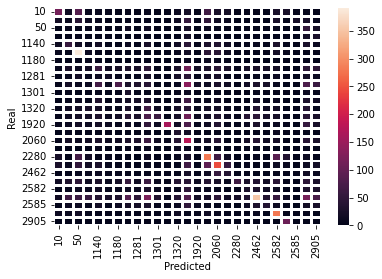

In [13]:
#Chemin du modèle  
MODEL_IMAGE_PATH = Path(PATH_MODELS, "image", MODEL_IMAGE_NAME)
MODEL_IMAGE_PATH.mkdir(parents=True, exist_ok=True)

#Génération des dataframes
df_train = pd.DataFrame(
            data=np.concatenate([X_train[:,0].reshape(-1, 1), y_train.reshape(-1, 1)], axis=1),
            columns=["links", "label"])

df_test = pd.DataFrame(
            data=np.concatenate([X_test[:,0].reshape(-1, 1), y_test_tr.reshape(-1, 1)], axis=1),
            columns=["links", "label"])
        
df_train["label"] = df_train["label"].apply(lambda x: str(x))
df_test["label"] = df_test["label"].apply(lambda x: str(x))
        
#Creations des générateurs
train_generator, test_generator = image_tools.flow_generators(
            df_train, df_test,
            TARGET_SHAPE, BATCH_SIZE
        )

if TRAIN_IMAGE:
  
  #Recuperation du modele
  model_image = image_tools.build_pipeline_model(
                name=MODEL_IMAGE_NAME,
                input_dim=TARGET_SHAPE,
            )
            
  #Lancement du Tensorboard
  %tensorboard --logdir $LOG_DIR_IMAGE

  #Entrainement et recuperation de l'historique
  model_image_hist = model_image.fit(
                train_generator,
                epochs=EPOCHS_IMAGE,
                verbose=0,
                validation_data=test_generator,
                callbacks=[
                        model_tools.get_model_checkpoint(MODEL_IMAGE_PATH), 
                        model_tools.get_dashboard(LOG_DIR_IMAGE),
                        model_tools.get_tqdm()
                        ]
            ) 

  if "history" in vars(model_image):
                plt.plot(model_image_hist.history['accuracy'])
                plt.plot(model_image_hist.history['val_accuracy'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.legend(['train', 'test'], loc='upper left')
                
                plt.savefig(Path(MODEL_IMAGE_PATH, 'history.jpg'))
                plt.clf()
#Sinon chargement d'un modele pour le texte
else:
  model_image = tf.keras.models.load_model(MODEL_IMAGE_PATH, compile=False)
#Prediction
y_image_preds = model_image.predict(test_generator)
y_image_preds_class = np.argmax(y_image_preds, axis=1) if len(y_image_preds.shape)==2 else y_image_preds

y_image_preds_class = le.inverse_transform(y_image_preds_class)

crosstab = pd.crosstab(y_test, y_image_preds_class, rownames=["Real"], colnames=["Predicted"])
print(classification_report_imbalanced(y_test, y_image_preds_class, zero_division=0))

heat = graphs.heatmap(crosstab)
plt.savefig(Path(MODEL_IMAGE_PATH, 'crosstab.jpg'))

#### Fusion

In [ ]:
if TRAIN_FUSION:
        #Chemin du modèle des texts 
        MODEL_FUSION_PATH = Path(PATH_MODELS, "fusion", MODEL_FUSION_NAME)
        MODEL_FUSION_PATH.mkdir(parents=True, exist_ok=True)

        model_fusion = models_fusion.model_multi_input(
            model_text, model_image
        )
        print(model_fusion.summary())

        X_train_tr = pipeline_preprocess_text.transform(X_train)
        print(X_train_tr[0])
        model_fusion_hist = model_fusion.fit(
            np.array([X_train_tr, train_generator]),
            epochs=EPOCHS_FUSION
        )

        y_fusion_preds = model_fusion.predict([X_test_tr, test_generator])
        y_fusion_preds_class = np.argmax(y_fusion_preds, axis=1)
        y_fusion_preds_class = le.inverse_transform(y_fusion_preds_class)

        crosstab = pd.crosstab(y_test, y_fusion_preds_class, rownames=["Real"], colnames=["Predicted"])
        print(classification_report_imbalanced(y_test, y_image_preds, zero_division=0))
        heat = graphs.heatmap(crosstab)
        plt.savefig(Path(MODEL_FUSION_PATH, 'crosstab.jpg'))